<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Evoked_Timescales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================
# 🧠 Compute Evoked Signals for each subject using NPI.model_ECt
# ============================================

# --- 1️⃣ Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- 2️⃣ Clone GitHub repo (contains src/NPI.py) ---
!rm -rf /content/BrainStim_ANN_fMRI_HCP
!git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git

# --- 3️⃣ Define paths ---
import os, sys, gc
repo_dir    = "/content/BrainStim_ANN_fMRI_HCP"
data_dir    = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
dataframe_dir  = os.path.join(data_dir, "dataframe")
preproc_dir = os.path.join(data_dir, "preprocessed_subjects")
models_dir  = os.path.join(preproc_dir, "trained_models_MLP")
ects_dir    = os.path.join(preproc_dir, "ECts_MLP")
os.makedirs(ects_dir, exist_ok=True)

if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# --- 4️⃣ Imports ---
import numpy as np
from scipy import stats
import torch
import torch.serialization
from src import NPI

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Repo loaded from:", repo_dir)
print("Using device:", device)

# --- 5️⃣ Choose which subjects to process ---
# either specify manually:
#subjects = ["id_100206"]
# or automatically detect all
subjects = sorted({fn.split("_signals.npy")[0]
                   for fn in os.listdir(preproc_dir)
                   if fn.endswith("_signals.npy")})

# --- 6️⃣ Allowlist your model classes (needed for PyTorch ≥2.6) ---
torch.serialization.add_safe_globals(
    [NPI.ANN_MLP, NPI.ANN_CNN, NPI.ANN_RNN, NPI.ANN_VAR]
)

# --- 7️⃣ Define helper to load model (full model or checkpoint) ---
def load_model(model_path, inputs, targets):
    ckpt = torch.load(model_path, map_location=device, weights_only=False)
    if hasattr(ckpt, "eval"):  # full model saved with torch.save(model)
        model = ckpt.to(device)
        model.eval()
        return model
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        method = ckpt.get("method", "MLP")
        ROI_num = ckpt.get("ROI_num", targets.shape[-1])
        using_steps = ckpt.get("using_steps", inputs.shape[-2] if inputs.ndim > 1 else 1)
        model = NPI.build_model(method, ROI_num, using_steps).to(device)
        model.load_state_dict(ckpt["model_state_dict"])
        model.eval()
        return model
    raise ValueError("Unrecognized model file format")

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 289, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 289 (delta 50), reused 10 (delta 10), pack-reused 173 (from 1)
Receiving objects: 100% (289/289), 30.94 MiB | 17.38 MiB/s, done.
Resolving deltas: 100% (91/91), done.
✅ Repo loaded from: /content/BrainStim_ANN_fMRI_HCP
Using device: cpu


In [2]:
subjects

['id_100206',
 'id_100307',
 'id_100408',
 'id_101006',
 'id_101107',
 'id_101309',
 'id_101915',
 'id_102008',
 'id_102109',
 'id_102311']

# Predict next step and study correlationbetween perturbed and unperturbed

In [56]:
import pandas as pd

# create an empty list to collect rows
rows = []

for i in range(10):
    print(i)
    sig_path = os.path.join(preproc_dir, f"{subjects[i]}_signals.npy")
    inp_path = os.path.join(preproc_dir, f"{subjects[i]}_inputs.npy")
    tgt_path = os.path.join(preproc_dir, f"{subjects[i]}_targets.npy")
    mdl_path = os.path.join(models_dir,  f"{subjects[i]}_MLP.pt")

    Z = np.load(sig_path)
    X = np.load(inp_path)             # (M, S*N)
    Y = np.load(tgt_path)             # (M, N)

    # Load model
    model = load_model(mdl_path, X, Y)

    S = 3
    N = Z.shape[1]
    n = 400
    M = 500

    dur = 1
    pert_strength = 0.1

    Patter_correlation = np.zeros((M, N))
    Net_effect = np.zeros((M, N))

    for node in range(N):
        for ini in range(M):
            perturbation = np.zeros((S, N), dtype=float)
            perturbation[-1, node] = pert_strength

            init_cond = np.reshape(X[ini, :], (S, N))

            perturbed = NPI.model_time_series(model, init_cond + perturbation, tlen=dur, noise_strength=0.)
            unperturbed = NPI.model_time_series(model, init_cond, tlen=dur, noise_strength=0.)

            Patter_correlation[ini, node] = stats.pearsonr(perturbed[-1, -n:], unperturbed[-1, -n:])[0]
            Net_effect[ini, node] = np.sum(perturbed[-1, -n:]**2)

    # Reduce (M,N) → (n,)
    Pattern_corr = np.mean(Patter_correlation, axis=0)[-n:]
    Net_effect_energy = np.mean(Net_effect, axis=0)[-n:]

    # ----------------------------
    # Append rows to dataframe list
    # ----------------------------
    for roi in range(n):
        rows.append({
            "sid": subjects[i],
            "roi": roi,
            "pattern_correlation": Pattern_corr[roi],
            "net_effect": Net_effect_energy[roi]
        })

# Convert list → DataFrame
df = pd.DataFrame(rows)


0
1
2
3
4
5
6
7
8
9


In [57]:
dataframe_dir  = os.path.join(data_dir, "dataframe")

# Save as CSV
df.to_csv(os.path.join(dataframe_dir, "net_response_measures.csv"),
          index=False)

# Also save as pickle for fast loading
df.to_pickle(os.path.join(dataframe_dir, "net_response_measures.pkl"))

In [60]:
np.asarray(df['pattern_correlation'])

array([0.99999847, 0.99999794, 0.99999869, ..., 0.99999857, 0.99999902,
       0.99999892])

In [53]:
for sid in range(1):
  sig_path = os.path.join(preproc_dir, f"{subjects[sid]}_signals.npy")
  inp_path = os.path.join(preproc_dir, f"{subjects[sid]}_inputs.npy")
  tgt_path = os.path.join(preproc_dir, f"{subjects[sid]}_targets.npy")
  mdl_path = os.path.join(models_dir,  f"{subjects[sid]}_MLP.pt")

  Z = np.load(sig_path)
  X = np.load(inp_path)             # (M, S*N)
  Y = np.load(tgt_path)             # (M, N)

  # Load model
  model = load_model(mdl_path, X, Y)

  S=3 #number of steps
  N=Z.shape[1] #number of regions
  n=400
  M=500 # initial times to consider

  dur=1 #predicted activity
  pert_strength=0.1

  Patter_correlation=np.zeros((M, N))
  Net_effect=np.zeros((M, N))
  #ECi=np.zeros((M, N, N))
  for node in range(50,54):
    for ini in range(M):
      # Build a perturbation that only hits the last step and a single node: (S, N)
      perturbation = np.zeros((S, N), dtype=float)
      perturbation[-1, node] = pert_strength

      init_cond=np.reshape(X[ini,:],(S,N))

      perturbed = NPI.model_time_series(model, init_cond + perturbation, tlen=dur, noise_strength=0.)
      unperturbed = NPI.model_time_series(model, init_cond, tlen=dur, noise_strength=0.)
      Patter_correlation[ini,node] = stats.pearsonr(perturbed[-1,-n:],unperturbed[-1,-n:])[0]
      Net_effect[ini,node] = np.sum(perturbed[-1,-n:]**2)
      #ECi[ini,node,:] += perturbed[-1,:]-unperturbed[-1,:]

  Patter_correlation=np.mean(Patter_correlation,axis=0)[-n:]  #(n,)
  Net_effect_energy=np.mean(Net_effect,axis=0)[-n:]  #(n,)
  #Responsiveness=np.sum(np.mean(ECi,axis=0)[-n:,-n:]**2,axis=1) #(n,)

In [55]:
Responsiveness

array([0.00043553, 0.000615  , 0.00037828, 0.00041758, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
0.000436
0.000615

In [52]:
np.arange(50,60)

array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

In [26]:
S=3 #number of steps
N=Z.shape[1] #number of regions
M=500 # initial times to consider

dur=1 #predicted activity
pert_strength=0.1

Patter_correlation=np.zeros((M, N))
Net_effect=np.zeros((M, N))
Responsiveness=np.zeros((M, N))
for node in range(N):
  for ini in range(M):
    # Build a perturbation that only hits the last step and a single node: (S, N)
    perturbation = np.zeros((S, N), dtype=float)
    perturbation[-1, node] = pert_strength

    init_cond=np.reshape(X[ini,:],(S,N))

    perturbed = NPI.model_time_series(model, init_cond + perturbation, tlen=dur, noise_strength=0.)
    unperturbed = NPI.model_time_series(model, init_cond, tlen=dur, noise_strength=0.)
    Patter_correlation[ini,node] = stats.pearsonr(perturbed[-1,:],unperturbed[-1,:])[0]
    Net_effect[ini,node] = np.sum(perturbed[-1,:]**2)
    Responsiveness[ini,node] = np.sum((perturbed[-1,:]-unperturbed[-1,:])**2)
prepostcorr1=np.mean(Patter_correlation,axis=0)[-400:]
net1=np.mean(Net_effect,axis=0)[-400:]
respo1=np.mean(Responsiveness,axis=0)[-400:]

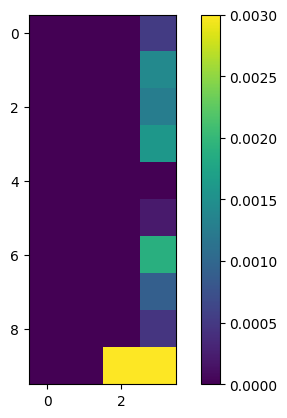

In [27]:
import matplotlib.pyplot as plt
plt.imshow((perturbed-unperturbed)[:,-10:].T,vmax=0.003)
plt.colorbar()

In [28]:
prepostcorr1=np.mean(Patter_correlation,axis=0)[-400:]
net1=np.mean(Net_effect,axis=0)[-400:]
respo1=np.mean(Responsiveness,axis=0)[-400:]

In [29]:
PG=np.asarray([-0.05277209,  0.01083288, -0.01978232, -0.06138297, -0.05316657,
        0.02421802,  0.04342252, -0.0313856 ,  0.03421375, -0.06232753,
       -0.07662802,  0.05684985,  0.0163275 ,  0.00572048,  0.07155598,
       -0.0029681 , -0.05484867,  0.01899668, -0.00246702,  0.05114801,
       -0.03646155, -0.00722474, -0.03706724, -0.05000584, -0.0499802 ,
       -0.04765047, -0.03340243, -0.04989991, -0.0520839 , -0.0467862 ,
       -0.08079112, -0.06672563, -0.01067749, -0.05120554, -0.08923878,
       -0.02659352, -0.09770474,  0.00294996, -0.05398697, -0.08968742,
       -0.09183452, -0.07267602, -0.07408797, -0.09582142, -0.00908836,
       -0.07590866, -0.0948794 , -0.02548302, -0.0719701 , -0.0574763 ,
       -0.0938623 , -0.08308646, -0.08556407, -0.08209742, -0.06000241,
       -0.05720705, -0.05558921, -0.08749367, -0.07555002, -0.092252  ,
       -0.0919002 , -0.07115512, -0.09706868, -0.06193651, -0.06664536,
       -0.01626201, -0.08914484, -0.06535804, -0.06020609, -0.02156996,
       -0.06645638, -0.08982807, -0.03656055, -0.05322744, -0.00184798,
       -0.09675361, -0.03078102, -0.06762154, -0.09661304, -0.04816749,
       -0.04274028, -0.08258195, -0.04240204, -0.06485024, -0.08168545,
       -0.08738569, -0.02257358, -0.07191397, -0.0357631 , -0.05180978,
       -0.06378945, -0.04709761, -0.02025925, -0.05427799, -0.01691179,
       -0.08035778,  0.00624413, -0.03809391,  0.00326954, -0.02777772,
       -0.02376571, -0.02560722,  0.07134367, -0.05846208, -0.00435665,
        0.00529407, -0.04161418, -0.09640483, -0.01772671, -0.05744066,
       -0.03900213, -0.05250283, -0.05721726, -0.00454546,  0.06628345,
        0.08634862,  0.0262401 ,  0.10918926,  0.02276326,  0.01890004,
        0.04354407,  0.08962103, -0.01799936,  0.12354378,  0.08236797,
        0.06777364,  0.07203834,  0.00597892,  0.08229102,  0.07944815,
        0.07224712,  0.03540389,  0.0750454 ,  0.05736408,  0.09225691,
        0.01082649,  0.02032694,  0.10816791,  0.08890128,  0.05087346,
        0.07598237,  0.00376547,  0.11793249,  0.03048419,  0.02021255,
       -0.02889123,  0.03774196,  0.07755153,  0.11793648,  0.13356609,
        0.09962192,  0.10853972, -0.09477755,  0.11632271,  0.01840049,
       -0.09088493, -0.06225061, -0.04186634, -0.09001049,  0.09599032,
        0.04162014,  0.13321379,  0.08762582,  0.11786813,  0.10687475,
        0.13089772,  0.08901088,  0.11615074,  0.12379297,  0.12118174,
        0.1097939 ,  0.02481425,  0.11903324,  0.10969502,  0.11779285,
        0.10912428,  0.08639344,  0.12172459,  0.12822399,  0.10213361,
        0.10673694,  0.13455502,  0.11532298,  0.12705671,  0.03108417,
        0.12834058,  0.13405145,  0.09921297, -0.04801311,  0.09321868,
        0.07154903,  0.12853199,  0.0755892 ,  0.06203157,  0.12493279,
        0.12510448,  0.09487973,  0.08288352,  0.11749262,  0.08475884,
       -0.06929148,  0.02937384, -0.01123253, -0.00449335, -0.0671833 ,
       -0.08151149,  0.01541759,  0.06190775, -0.03970393,  0.00434116,
       -0.06940454, -0.06936388,  0.05552906, -0.02440949,  0.06166277,
       -0.08411124,  0.04944063, -0.00211739, -0.02170159, -0.03657738,
       -0.00326688, -0.04325624, -0.04554298, -0.0579833 , -0.04150799,
       -0.0369826 , -0.06296609, -0.05740583, -0.05206344, -0.06246283,
       -0.0814589 , -0.04290943, -0.03089225, -0.05971348, -0.08177954,
       -0.00997497, -0.07469537, -0.08395408, -0.05354743, -0.06012279,
       -0.05800791, -0.09364154, -0.0907659 , -0.07183779, -0.05562918,
       -0.06981361, -0.06735356, -0.06992313, -0.05485618, -0.04287897,
       -0.09422754, -0.06662054, -0.0806462 , -0.07741665, -0.0897629 ,
       -0.06123065, -0.09498177, -0.09657309, -0.05942257, -0.07502361,
       -0.06450427, -0.08506763, -0.05865335, -0.00298919, -0.07472709,
       -0.09285935, -0.0598787 , -0.05270952, -0.05292144, -0.07831596,
       -0.03660487, -0.06528687, -0.0955566 ,  0.00775444, -0.05072453,
       -0.0696473 ,  0.00885346, -0.06846895, -0.07011052, -0.02106507,
       -0.02771488, -0.07599091, -0.06871435, -0.07855759,  0.01368273,
       -0.08649025, -0.0446091 , -0.05531936, -0.06278142, -0.08610476,
       -0.04677627, -0.09647438, -0.03977824, -0.07279473, -0.09365498,
       -0.05754486, -0.0508712 , -0.03973454, -0.02978154,  0.03653674,
       -0.08274289, -0.07906881, -0.04472453, -0.04209499, -0.05309856,
       -0.0309739 , -0.05030773, -0.04948422, -0.02065795, -0.01805169,
       -0.02694789, -0.0632735 , -0.00205695, -0.08845603, -0.05428114,
       -0.04777741, -0.0581926 , -0.05599566,  0.06189745,  0.01472433,
        0.05729775,  0.08220592,  0.1142404 ,  0.12406897,  0.00976013,
        0.01064498,  0.00136563, -0.08653303, -0.03701307, -0.02884743,
        0.05564063,  0.1165014 ,  0.03888763,  0.05987078, -0.02569706,
        0.01457415,  0.06858648,  0.0393338 ,  0.05325408,  0.08201455,
        0.02798006,  0.04937692,  0.12656908, -0.01536845, -0.00315699,
       -0.02898865, -0.06747772,  0.00778672,  0.05550295,  0.04965211,
        0.00179113,  0.12613498,  0.04639424,  0.0982925 , -0.03784215,
        0.04072895,  0.12631995,  0.03199747,  0.04499186,  0.06724152,
        0.07955665, -0.00025688,  0.01097878,  0.12823518,  0.09996226,
        0.12704102,  0.06408599,  0.12774251, -0.04969536, -0.02068008,
        0.08715103, -0.0473488 ,  0.08530809, -0.02854597,  0.12300966,
        0.08815575,  0.05080998,  0.08087541,  0.09583243,  0.10887443,
        0.10388634,  0.13265311,  0.12959051,  0.04793795,  0.12203533,
        0.12584031,  0.09255735,  0.12171592,  0.12282255,  0.11192263,
        0.06002949,  0.06338771,  0.06528479,  0.05271662,  0.12328157,
        0.12856894,  0.07389757,  0.08177554,  0.12448514,  0.01467009])

Correlation (PG vs prepostcorr1): -0.4010
P-value: 6.9377e-17


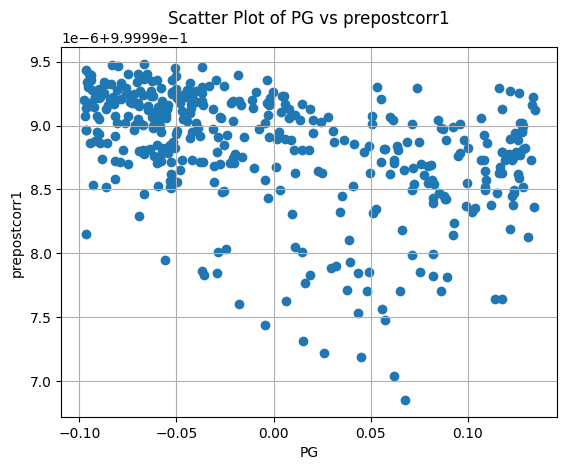

In [31]:
# Compute correlation
xxx=PG
yyy=prepostcorr1
corr, p_value = stats.pearsonr(xxx,yyy)
print(f"Correlation (PG vs prepostcorr1): {corr:.4f}")
print(f"P-value: {p_value:.4e}")
plt.scatter(xxx,yyy)
plt.xlabel("PG"); plt.ylabel("prepostcorr1")
plt.title("Scatter Plot of PG vs prepostcorr1")
plt.grid(True)
plt.show()

Correlation (PG vs prepostcorr1): -0.1519
P-value: 2.3150e-03


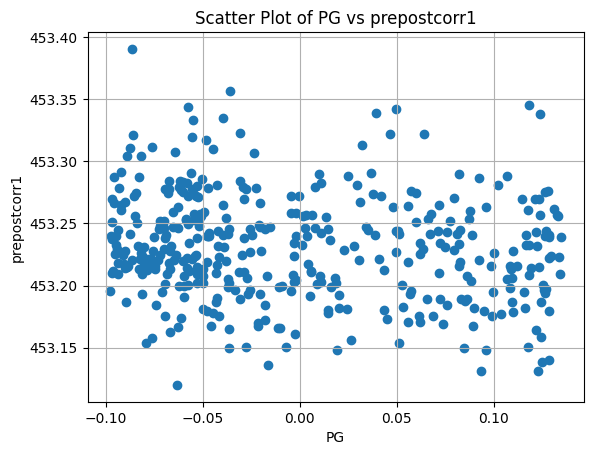

In [32]:
# Compute correlation
xxx=PG
yyy=net1
corr, p_value = stats.pearsonr(xxx,yyy)
print(f"Correlation (PG vs prepostcorr1): {corr:.4f}")
print(f"P-value: {p_value:.4e}")
plt.scatter(xxx,yyy)
plt.xlabel("PG"); plt.ylabel("prepostcorr1")
plt.title("Scatter Plot of PG vs prepostcorr1")
plt.grid(True)
plt.show()

Correlation (PG vs prepostcorr1): 0.3949
P-value: 2.2434e-16


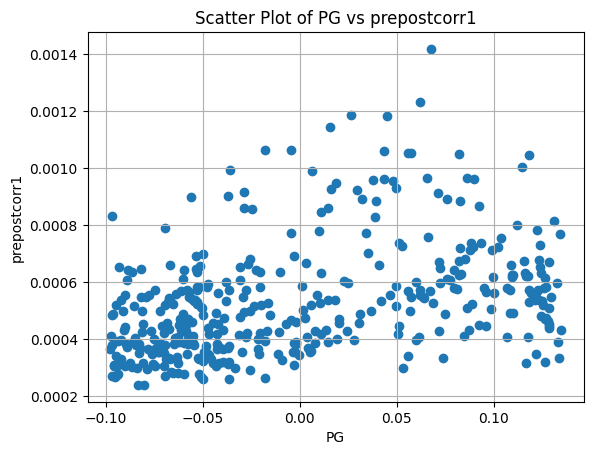

In [33]:
# Compute correlation
xxx=PG
yyy=respo1
corr, p_value = stats.pearsonr(xxx,yyy)
print(f"Correlation (PG vs prepostcorr1): {corr:.4f}")
print(f"P-value: {p_value:.4e}")
plt.scatter(xxx,yyy)
plt.xlabel("PG"); plt.ylabel("prepostcorr1")
plt.title("Scatter Plot of PG vs prepostcorr1")
plt.grid(True)
plt.show()

# Example simulate single subject time series

In [3]:
# Single subject plots
sig_path = os.path.join(preproc_dir, f"{subjects[0]}_signals.npy")
inp_path = os.path.join(preproc_dir, f"{subjects[0]}_inputs.npy")
tgt_path = os.path.join(preproc_dir, f"{subjects[0]}_targets.npy")
mdl_path = os.path.join(models_dir,  f"{subjects[0]}_MLP.pt")

Z = np.load(sig_path)
X = np.load(inp_path)             # (M, S*N)
Y = np.load(tgt_path)             # (M, N)

# Load model
model = load_model(mdl_path, X, Y)

In [ ]:
S=3 #number of steps
N=Z.shape[1] #number of regions
M=500 # initial times to consider

dur=30 #predicted activity
pert_strength=0.1

Zsim=np.zeros((N, dur+3, N))
for node in range(2):
  print(node)
  for ini in range(M):
    # Build a perturbation that only hits the last step and a single node: (S, N)
    perturbation = np.zeros((S, N), dtype=float)
    perturbation[-1, node] = pert_strength

    init_cond=np.reshape(X[ini,:],(S,N))

    perturbed = NPI.model_time_series(model, init_cond + perturbation, tlen=dur, noise_strength=0.)
    unperturbed = NPI.model_time_series(model, init_cond, tlen=dur, noise_strength=0.)
    Zsim[node,:,:] += perturbed - unperturbed
  Zsim[node,:,:]/=M

0
1


In [ ]:
Zsim.shape

(450, 33, 450)

In [ ]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

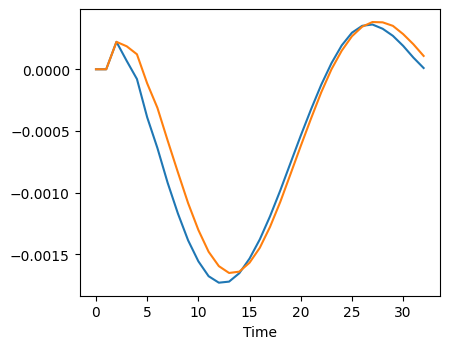

In [ ]:
plt.figure(figsize=(4.6,3.6))
plt.plot(np.mean(Zsim[0,:,:],axis=1))
plt.plot(np.mean(Zsim[1,:,:],axis=1))
plt.xlabel('Time')
#plt.axis('off')
plt.tight_layout()
plt.show()

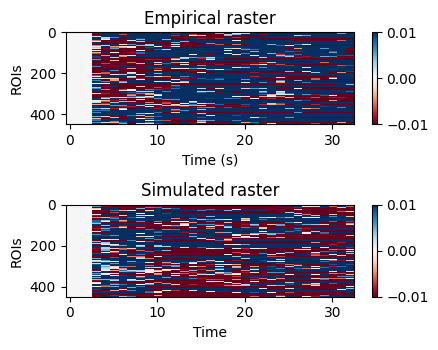

In [ ]:
plt.figure(figsize=(4.6,3.6))
plt.subplot(2,1,1)
plt.title('Empirical raster')
plt.imshow(Zsim[0,:,:].T,aspect='auto',vmin=-.01,vmax=.01,cmap='RdBu',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('ROIs')
plt.subplot(2,1,2)
plt.title('Simulated raster')
plt.imshow(Zsim[1,:,:].T,aspect='auto',vmin=-.01,vmax=.01,cmap='RdBu',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('ROIs')
#plt.axis('off')
plt.tight_layout()
plt.show()